# Analysis of a Sodium-cooled Fast Reactor Unit Cell

In [1]:
import openmc
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#uncomment the following line on beocat
#openmc.config["cross_sections"] = "/homes/jaroberts/data/cross_sections.xml"

## Material Definitions

The material compositions come from the report.

### Fuel Composition

The fuel composition represents the initial composition in an "equilibrium" cycle.

In [3]:
fuel_composition = {'O16': 4.28E-02,
 'U234': 2.02E-06, 'U235': 3.22E-05, 'U236': 3.90E-06, 'U238': 1.81E-02,
 'Np237': 4.65E-06, 'Np239': 3.33E-06,
 'Pu238': 1.08E-04, 'Pu239': 1.98E-03, 'Pu240': 1.16E-03, 'Pu241': 2.46E-04, 'Pu242': 3.76E-04,
 'Am241': 4.64E-05, 'Am242': 1.36E-06, 'Am243': 2.75E-05,
 'Cm242': 2.42E-06, 'Cm243': 1.15E-07, 'Cm244': 3.87E-06, 'Cm245': 1.91E-07, 'Cm246': 5.29E-09}

In [4]:
fuel = openmc.Material(name="fuel")
for i in fuel_composition:
    fuel.add_nuclide(i, fuel_composition[i], 'ao')
# per the report, Mo is added as a "representative" fission product    
fuel.add_element("Mo", 7e-4, 'ao')
fuel.set_density('g/cm3', 10.0)

In [5]:
coolant =  openmc.Material(name="coolant") 
coolant.add_nuclide("Na23", 2.1924e-2)
coolant.set_density('g/cm3', 0.837)

In [6]:
cladding_composition = {
    "C":  3.5740E-04, "O":  3.9924E-04, "Ti": 5.3824E-04, "Cr": 1.7753E-02,
    "Fe": 5.3872E-02, "Ni": 3.6588E-04, "Mn": 2.3441E-04, "P":  2.7718E-05,
    "Al": 9.1482E-03, "Co": 2.1852E-04, "Cu": 1.0135E-04, "Y":  2.6616E-04}
cladding = openmc.Material(name="cladding")
for i in cladding_composition:
    cladding.add_element(i, cladding_composition[i], 'ao')
cladding.set_density('g/cm3', 7.13)

In [7]:
# A volume averaged mixture (check fractions!)
mix = openmc.Material.mix_materials(
    [fuel,cladding,coolant], 
    [0.4109945671143482, 0.16362416961349094, 0.42538126327216086], 'vo')

In [8]:
materials = openmc.Materials([fuel, coolant, cladding, mix])
materials.export_to_xml()

## Geometry Definitions

The area of a regular hexagon is 

$$
 A_{\text{hex}} = \frac{3\sqrt{3}}{2}s^2 = 3hs 
$$
 
where $s$ is the side length and $h$ is the half pitch (or "apothem").

In [9]:
h_assembly = 16.2471/2  # the assembly half pitch
s_assembly = 2*h_assembly / np.sqrt(3)
area_assembly = 3*h_assembly*s_assembly
area_unit = area_assembly / 271
h_unit = np.sqrt(area_unit*(2*np.sqrt(3))/3)/2
s_unit = 2*h_unit / np.sqrt(3)
h_unit, s_unit, area_unit

(0.49347051939782594, 0.5698106744229585, 0.8435543083977686)

In [10]:
r_fuel = 0.3322; area_fuel = np.pi*r_fuel**2
r_clad = 0.3928; area_clad = np.pi*(r_clad**2 - r_fuel**2)
area_cool = area_unit - area_clad - area_fuel
vf_fuel = area_fuel / area_unit
vf_clad = area_clad / area_unit
vf_cool = area_cool / area_unit
vf_fuel, vf_clad, vf_cool # compare tp Table 28 for the active core (HT9 is the cladding and is a type of SS)

(0.4109945671143482, 0.16362416961349094, 0.42538126327216086)

### Infinite Medium

In [11]:
# radius = 1.0
# sphere = openmc.Sphere(r=radius, boundary_type='reflective')
# stuff = openmc.Cell(name='fuel')
# stuff.fill = mix
# stuff.region = -sphere # the "-" means "inside of"
# root_universe = openmc.Universe(cells=[stuff])
# geometry = openmc.Geometry(root_universe)
# geometry.export_to_xml()

### Hexagonal Unit Cell

In [12]:
fuel_surface = openmc.ZCylinder(r=r_fuel)
clad_surface = openmc.ZCylinder(r=r_clad)
outer_surface = openmc.model.hexagonal_prism(
                  edge_length=s_unit,
                  orientation='x',
                  boundary_type='reflective')

In [13]:
fuel_region = -fuel_surface
clad_region = +fuel_surface & -clad_surface
cool_region = +clad_surface & outer_surface

In [14]:
fuel_cell = openmc.Cell(name='fuel')
fuel_cell.fill = fuel
fuel_cell.region = fuel_region

clad_cell = openmc.Cell(name='cladding')
clad_cell.fill = cladding
clad_cell.region = clad_region

cool_cell = openmc.Cell(name='coolant')
cool_cell.fill = coolant
cool_cell.region = cool_region

In [15]:
root_universe = openmc.Universe(cells=(fuel_cell, clad_cell, cool_cell))
geometry = openmc.Geometry()
geometry.root_universe = root_universe
geometry.export_to_xml()

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

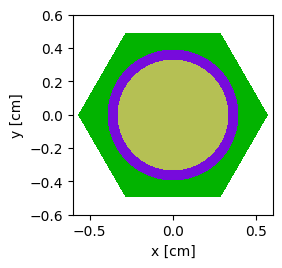

In [16]:
root_universe.plot(width=(1.2, 1.2))

## Settings

In [17]:
# Use 1 MeV point source at the origin as the starting source
point = openmc.stats.Point((0, 0, 0))
source = openmc.IndependentSource(space=point)
source.angle = openmc.stats.Isotropic()
source.energy = openmc.stats.Discrete([1e6], [1.0])
settings = openmc.Settings()
settings.batches = 20
settings.inactive = 5
settings.particles = 10000 # use 1e6 for a less noisy flux
settings.run_mode = 'eigenvalue'
settings.export_to_xml()

## Tallies

First, we define a tally for the neutron flux spectrum in each of the three regions.  We'll use a 10000-group structure from 1 eV to 100 MeV

In [18]:
cell_filter = openmc.CellFilter([fuel_cell, clad_cell, cool_cell])
E_bounds = np.logspace(0, 8, 10001)
spectrum_filter = openmc.EnergyFilter(E_bounds)
spectrum_tally = openmc.Tally(1)
spectrum_tally.filters = [cell_filter, spectrum_filter]
spectrum_tally.scores = ['flux']
tallies = openmc.Tallies([spectrum_tally])
tallies.export_to_xml()

## One-Group Cross Sections

OpenMC has functions to help produce group-wise cross sections both for individual nuclides and for macroscopic material definitions.

In [20]:
import openmc.mgxs as mgxs

# Instantiate a 2-group EnergyGroups object
groups = mgxs.EnergyGroups(np.array([1.0, 2.5e7]))
absorption_fuel = mgxs.AbsorptionXS(domain=fuel_cell, energy_groups=groups, by_nuclide=False)
absorption_clad = mgxs.AbsorptionXS(domain=clad_cell, energy_groups=groups, by_nuclide=False)
absorption_cool = mgxs.AbsorptionXS(domain=cool_cell, energy_groups=groups, by_nuclide=False)
nu_fission_fuel = mgxs.FissionXS(domain=fuel_cell, energy_groups=groups, by_nuclide=False, nu=True)

tallies += absorption_fuel.tallies.values()
tallies += absorption_clad.tallies.values()
tallies += absorption_cool.tallies.values()
tallies += nu_fission_fuel.tallies.values()

tallies.export_to_xml()

/home/robertsj/Research/openmc/openmc/mixin.py:70: IDWarning: Another Filter instance already exists with id=4.
  warn(msg, IDWarning)
/home/robertsj/Research/openmc/openmc/mixin.py:70: IDWarning: Another Filter instance already exists with id=3.
  warn(msg, IDWarning)


In [21]:
openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

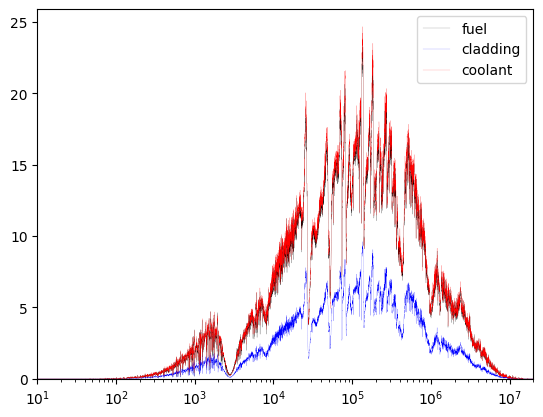

In [22]:
sp = openmc.StatePoint('statepoint.20.h5')

phi = sp.get_tally().mean.reshape((3,len(E_bounds)-1)).T

phi_fuel = phi[:, 0] / np.diff(E_bounds)
phi_clad = phi[:, 1] / np.diff(E_bounds)
phi_cool = phi[:, 2] / np.diff(E_bounds)

E_center = (E_bounds[:-1]+E_bounds[1:])/2

plt.stairs(E_center*phi_fuel, E_bounds, color='k', lw=0.1, label='fuel')
plt.stairs(E_center*phi_clad, E_bounds, color='b', lw=0.1, label='cladding')
plt.stairs(E_center*phi_cool, E_bounds, color='r', lw=0.1, label='coolant')
plt.xscale('log')
plt.legend()
plt.xlim(10, 2e7);

In [23]:
absorption_fuel.load_from_statepoint(sp)
absorption_clad.load_from_statepoint(sp)
absorption_cool.load_from_statepoint(sp)
nu_fission_fuel.load_from_statepoint(sp)

In [25]:
absorption_fuel.print_xs()
absorption_clad.print_xs()
absorption_cool.print_xs()
nu_fission_fuel.print_xs()

Multi-Group XS
	Reaction Type  =	absorption
	Domain Type    =	cell
	Domain ID      =	1
	Cross Sections [cm^-1]:
            Group 1 [1.0        - 25000000.0eV]:	1.35e-02 +/- 2.96e-01%



Multi-Group XS
	Reaction Type  =	absorption
	Domain Type    =	cell
	Domain ID      =	2
	Cross Sections [cm^-1]:
            Group 1 [1.0        - 25000000.0eV]:	8.19e-04 +/- 8.96e-01%



Multi-Group XS
	Reaction Type  =	absorption
	Domain Type    =	cell
	Domain ID      =	3
	Cross Sections [cm^-1]:
            Group 1 [1.0        - 25000000.0eV]:	4.03e-05 +/- 4.37e-01%



Multi-Group XS
	Reaction Type  =	nu-fission
	Domain Type    =	cell
	Domain ID      =	1
	Cross Sections [cm^-1]:
            Group 1 [1.0        - 25000000.0eV]:	1.69e-02 +/- 2.48e-01%





In [32]:
nuSigmaF_fuel = nu_fission_fuel.get_xs()[0]
SigmaA_fuel = absorption_fuel.get_xs()[0]
SigmaA_clad = absorption_clad.get_xs()[0]
SigmaA_cool = absorption_cool.get_xs()[0]

vf_fuel*nuSigmaF_fuel / (vf_fuel*SigmaA_fuel + vf_clad*SigmaA_clad + vf_cool*SigmaA_cool)

1.216137223647281